In [12]:
#匯入套件與設定環境
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests

792 182


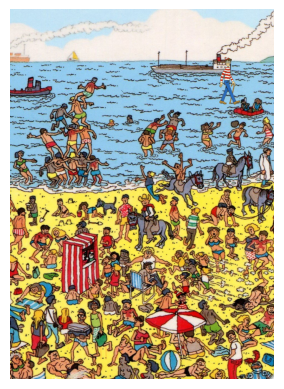

In [13]:
#讀取圖片與前處理(固定圖片尺寸，將威利合成到背景中)
BG_WIDTH = 1000
BG_HEIGHT = 1400
WALDO_WIDTH = 80
WALDO_HEIGHT = 180

def generate_sample_image():
    # 背景
    bg_url = "https://raw.githubusercontent.com/Zong0120/Where_is_Waldo/main/bg07.jpg"
    bg_response = requests.get(bg_url)
    bg_array = np.frombuffer(bg_response.content, np.uint8)
    bg = cv2.imdecode(bg_array, cv2.IMREAD_COLOR)
    bg_resized = cv2.resize(bg, (BG_WIDTH, BG_HEIGHT))
    bg_rgb = cv2.cvtColor(bg_resized, cv2.COLOR_BGR2RGB)

    # 威利
    waldo_url = "https://raw.githubusercontent.com/Zong0120/Where_is_Waldo/main/waldo.png"
    waldo_response = requests.get(waldo_url)
    waldo_array = np.frombuffer(waldo_response.content, np.uint8)
    waldo = cv2.imdecode(waldo_array, cv2.IMREAD_UNCHANGED)
    waldo_resized = cv2.resize(waldo, (WALDO_WIDTH, WALDO_HEIGHT))
    waldo_rgb = cv2.cvtColor(waldo_resized[:, :, :3], cv2.COLOR_BGR2RGB)
    alpha_mask = waldo_resized[:, :, 3] / 255.0  # 取出Alpha通道並正規化到0-1

    # 隨機產生waldo出現的座標，避免超出bg範圍
    col_range = (0, BG_WIDTH - WALDO_WIDTH)
    row_range = (0, BG_HEIGHT - WALDO_HEIGHT)
    col = np.random.randint(*col_range)
    row = np.random.randint(*row_range)

    # alpha_mask為0，表示完全透明，背景不變
    for c in range(3):
        bg_rgb[row:row+WALDO_HEIGHT, col:col+WALDO_WIDTH, c] = (
            alpha_mask * waldo_rgb[:, :, c] +
            (1 - alpha_mask) * bg_rgb[row:row+WALDO_HEIGHT, col:col+WALDO_WIDTH, c]
        )

    return bg_rgb, (col, row)

# 測試函式
bg_rgb, (col, row) = generate_sample_image()
plt.imshow(bg_rgb)
plt.axis("off")
print(col, row)
plt.show()

792 182


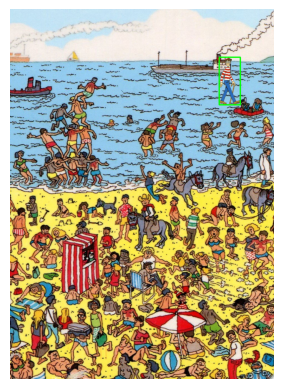

In [14]:
#繪製邊界框(正確答案為綠色外框，偵測結果為紅色外框)
def plot_bounding_box(image, ground_truth_pos, prediction_pos = None):

  cv2.rectangle(image, (ground_truth_pos[0], ground_truth_pos[1]),
             (ground_truth_pos[0] + WALDO_WIDTH, ground_truth_pos[1] + WALDO_HEIGHT),
             (0, 255, 0), 3)
  if prediction_pos is not None:
    cv2.rectangle(image, (prediction_pos[0], prediction_pos[1]),
               (prediction_pos[0] + WALDO_WIDTH, prediction_pos[1] + WALDO_HEIGHT),
               (255, 0, 0), 3)
  return image

#測試函式
image = plot_bounding_box(bg_rgb, (col, row))
plt.imshow(image)
plt.axis("off")
print(col, row)
plt.show()

In [15]:
#產生訓練圖片
def generate_data(batch_size = 16):

  while True:
    batch = np.zeros((batch_size, BG_HEIGHT, BG_WIDTH, 3))
    bounding_box = np.zeros((batch_size, 2))

    for i in range(batch_size):
      sample_image, pos = generate_sample_image()
      batch[i] = sample_image / 255 #正規化
      bounding_box[i, 0] = pos[0]
      bounding_box[i, 1] = pos[1]

    yield batch, bounding_box

#測試函式
train_data = generate_data()
batch, bounding_box = next(train_data) #產生一個批次的訓練資料(16組的圖片和二維座標)
print(batch.shape)
print(bounding_box.shape)

(16, 1400, 1000, 3)
(16, 2)


In [16]:
#模型評估指標，平均IoU
def mean_iou(y_true, y_pred):

  y_true = tf.cast(y_true, tf.float32)  #確保 y_true 是 float32
  y_pred = tf.cast(y_pred, tf.float32)  #確保 y_pred 是 float32

  #取得預測框的座標
  pred_x_min, pred_y_min = y_pred[:, 0], y_pred[:, 1]
  pred_x_max = pred_x_min + WALDO_WIDTH
  pred_y_max = pred_y_min + WALDO_HEIGHT

  #取得真實框的座標
  true_x_min, true_y_min = y_true[:, 0], y_true[:, 1]
  true_x_max = true_x_min + WALDO_WIDTH
  true_y_max = true_y_min + WALDO_HEIGHT

  #計算交集區域
  x1 = tf.maximum(true_x_min, pred_x_min)
  y1 = tf.maximum(true_y_min, pred_y_min)
  x2 = tf.minimum(true_x_max, pred_x_max)
  y2 = tf.minimum(true_y_max, pred_y_max)

  inter_width = tf.maximum(x2 - x1, 0)
  inter_height = tf.maximum(y2 - y1, 0)
  inter_area = inter_width * inter_height

  #計算聯集區域
  true_area = WALDO_WIDTH * WALDO_HEIGHT
  pred_area = WALDO_WIDTH * WALDO_HEIGHT
  union_area = true_area + pred_area - inter_area

  #計算IoU，避免除以0
  iou = inter_area / tf.maximum(union_area, tf.keras.backend.epsilon())

  #若預測框超出影像範圍，則IoU = 0
  out_of_bounds = tf.logical_or(
      tf.logical_or(pred_x_min < 0, pred_y_min < 0),
      tf.logical_or(pred_x_max > BG_WIDTH, pred_y_max > BG_HEIGHT)
  )

  iou = tf.where(out_of_bounds, 0.0, iou)

  return tf.reduce_mean(iou)

#測試函式
#y_true(真實框)
y_true = np.array([[100, 200], [300, 400], [500, 600]], dtype=np.float32)

#y_pred(預測框)
y_pred = np.array([[105, 205], [290, 390], [-100, 2000]], dtype=np.float32)
#          接近y_true  離y_true較遠 預測框超出範圍

#轉換為 TensorFlow Tensor
y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float32)

#計算 mean_IoU
iou_result = mean_iou(y_true_tf, y_pred_tf)

#執行 TensorFlow 計算
iou_value = iou_result.numpy()

print(f"Mean IoU: {iou_value:.4f}")

Mean IoU: 0.5138


In [17]:
#定義模型架構
#卷積層
def convolutional_block(inputs):

  x = tf.keras.layers.Conv2D(8, 3, padding = 'same', activation = 'relu')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(32, 3, padding = 'valid', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(32, 3, padding = 'valid', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  return x

#迴歸層(全連接層)
def regression_block(x):

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation = 'relu')(x)
  x = tf.keras.layers.Dense(256, activation = 'relu')(x)
  x = tf.keras.layers.Dense(2)(x)

  return x

#自行定義的函式，用於觀察訓練過程
def test_model():

  fig, ax = plt.subplots(1, 3, figsize = (15, 5))

  for i in range(3):
    #取得測試圖片
    sample_image, pos = generate_sample_image()
    sample_image_normalized = sample_image.reshape(1, BG_HEIGHT, BG_WIDTH, 3) / 255

    #使用模型偵測
    predicted_box = model.predict(sample_image_normalized)
    predicted_box = np.round(predicted_box[0]).astype(int)
    print("predicted_box:", predicted_box)

    #繪製邊界框
    img = plot_bounding_box(sample_image, pos, predicted_box)

    ax[i].imshow(img)
    ax[i].axis("off")

  plt.show()

#每2個epoch觀察一次訓練結果(ex:第1次, 第3次, 第5次)
class VisCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs = None):
    if epoch % 2 == 0:
      test_model()

#每5個epoch調整一次學習率，加速收斂
def learning_rate_schedule(epoch, lr):

  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7) #學習率最低為0.0000003

#建立模型
inputs = tf.keras.Input((BG_HEIGHT, BG_WIDTH, 3))
x = convolutional_block(inputs)
box_output = regression_block(x)
model = tf.keras.Model(inputs = inputs, outputs = box_output)

#編譯模型
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = [mean_iou])

In [ ]:
#每5個epoch建立一次檢查點
import os
from google.colab import drive
from datetime import datetime

#掛載google雲端硬碟
try:
  drive.mount("/content/drive")
  print("Google Drive 掛載成功！")
except Exception as e:
  print("掛載 Google Drive 失敗:", e)

#資料夾不存在則建立一個
checkpoint_dir = "/content/drive/MyDrive/WheresWaldo/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

#設定檢查點名稱(包含epoch）
checkpoint_path = os.path.join(checkpoint_dir, "WheresWaldo_epoch-{epoch:02d}.keras")

#建立 ModelCheckpoint 回調函數
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,      #檢查點儲存路徑
    save_weights_only=False,       #儲存整個模型（包括架構與權重）
    save_freq="epoch",          #每個epoch檢查是否符合條件
    period=5,              #每5個epoch儲存一次
    save_best_only=False,        #不限制只存最佳模型，確保每5個epoch儲存一次
)

#限制最多保留2個檔案（舊的會被刪除）
checkpoint_manager = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "WheresWaldo_checkpoint.keras"),
    save_weights_only=False,
    save_best_only=False,
    period=5,
    max_to_keep=2  #最多保留2個檢查點
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted_box: [346 360]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
predicted_box: [347 362]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
predicted_box: [344 360]


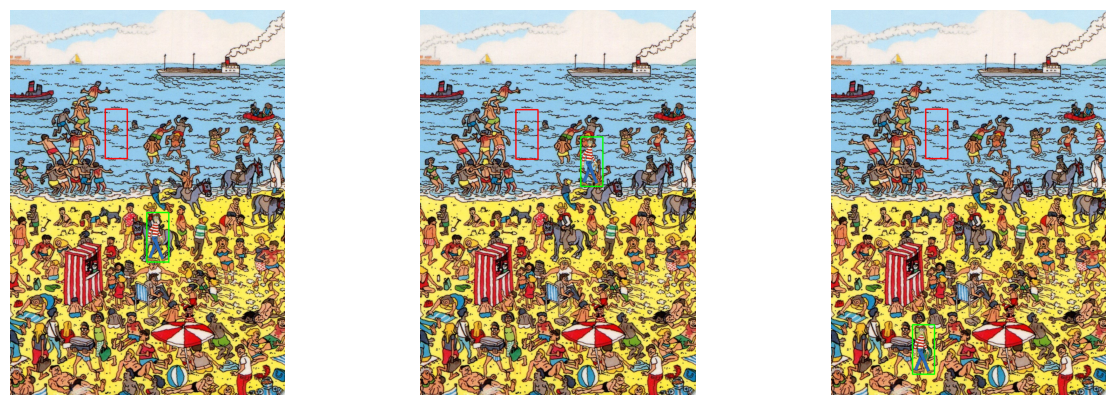

100/100 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - loss: 195443.0000 - mean_iou: 0.0130 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - loss: 3267.2161 - mean_iou: 0.3151 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
predicted_box: [288 909]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
predicted_box: [282 917]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
predicted_box: [282 919]


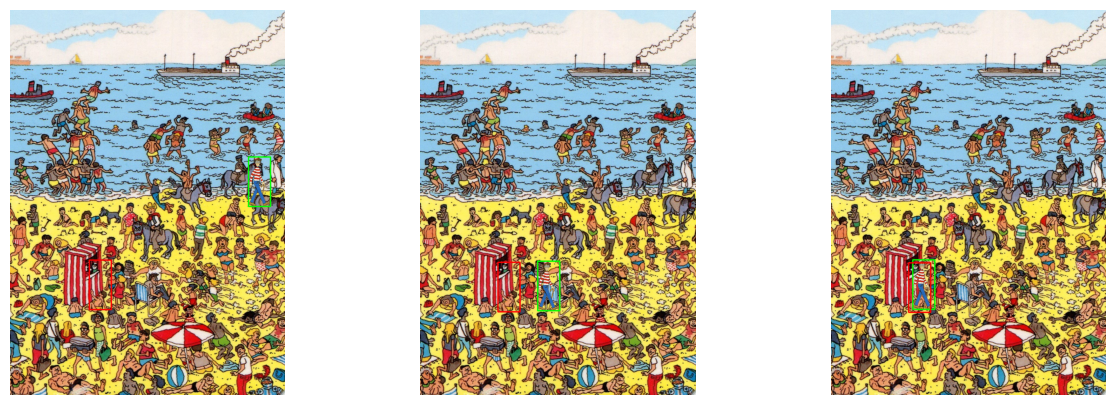

100/100 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - loss: 736.6791 - mean_iou: 0.5681 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - loss: 546.1987 - mean_iou: 0.5997 - learning_rate: 0.0010
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
predicted_box: [ 388 1341]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
predicted_box: [ 283 1218]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
predicted_box: [ 439 1131]


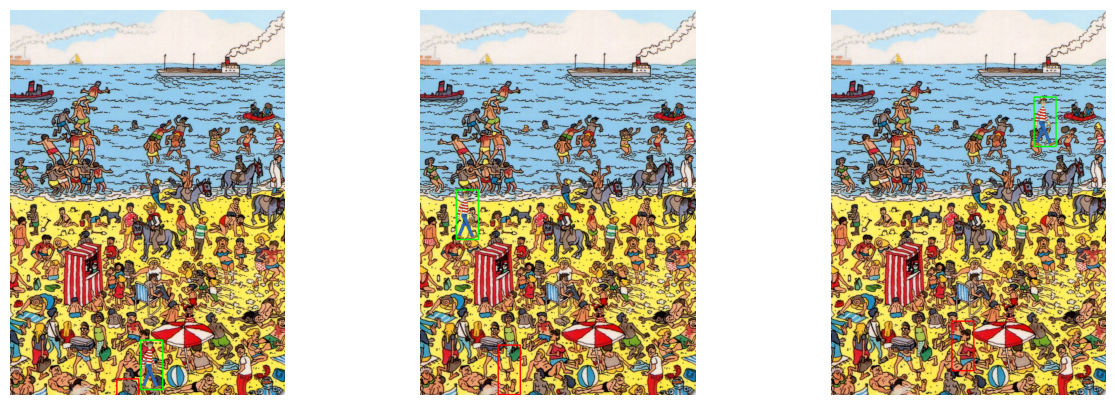

100/100 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - loss: 277.1951 - mean_iou: 0.6930 - learning_rate: 2.0000e-04
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - loss: 172.8144 - mean_iou: 0.7602 - learning_rate: 2.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
predicted_box: [ 430 1218]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted_box: [878 387]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
predicted_box: [ 349 1038]


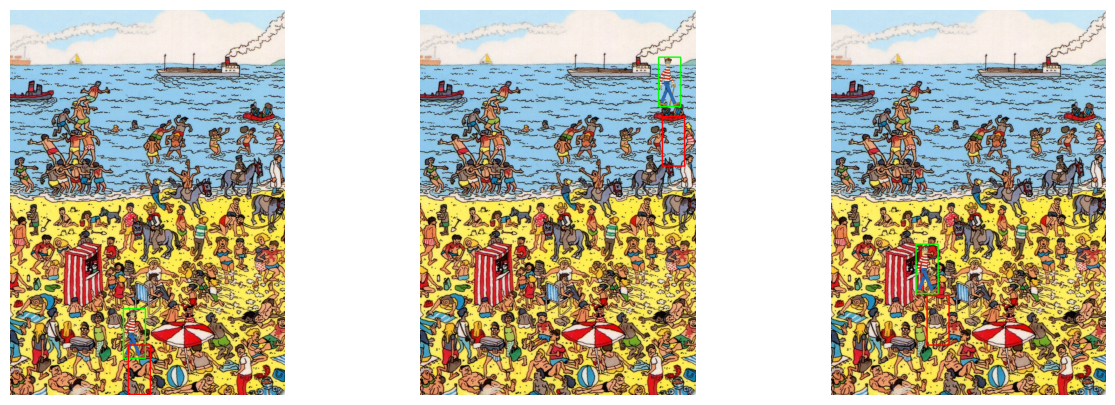

100/100 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - loss: 180.0222 - mean_iou: 0.7710 - learning_rate: 2.0000e-04
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - loss: 137.3479 - mean_iou: 0.7769 - learning_rate: 2.0000e-04
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
predicted_box: [634 221]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
predicted_box: [ 769 1200]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
predicted_box: [ 345 1033]


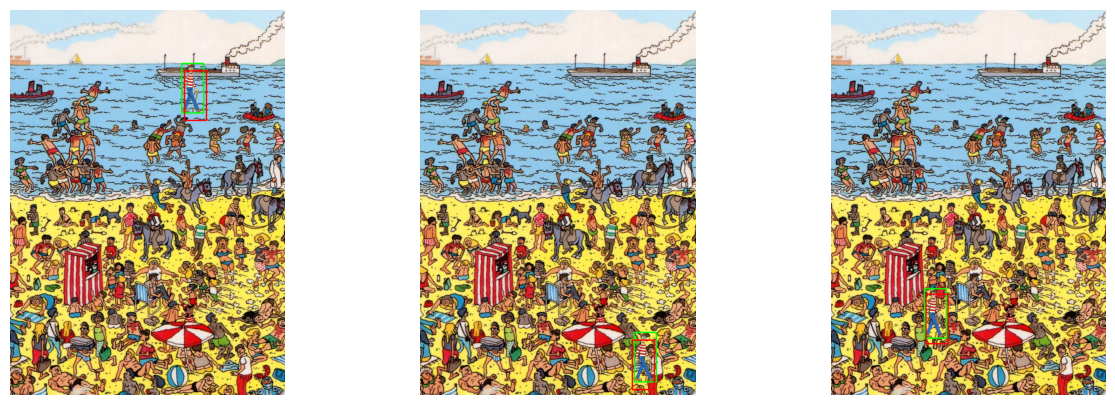

100/100 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - loss: 136.6781 - mean_iou: 0.7827 - learning_rate: 2.0000e-04
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - loss: 112.8982 - mean_iou: 0.8038 - learning_rate: 4.0000e-05


In [ ]:
#訓練模型(每個step產生16張圖片，每個epoch跑100次step，總共10個epoch)
model.fit(generate_data(), epochs = 10, steps_per_epoch = 100,
     callbacks = [VisCallback(), tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule),
             checkpoint_callback, checkpoint_manager])

100/100 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - loss: 164.5723 - mean_iou: 0.7582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
predicted_box: [579 773]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
predicted_box: [274 445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
predicted_box: [208 887]


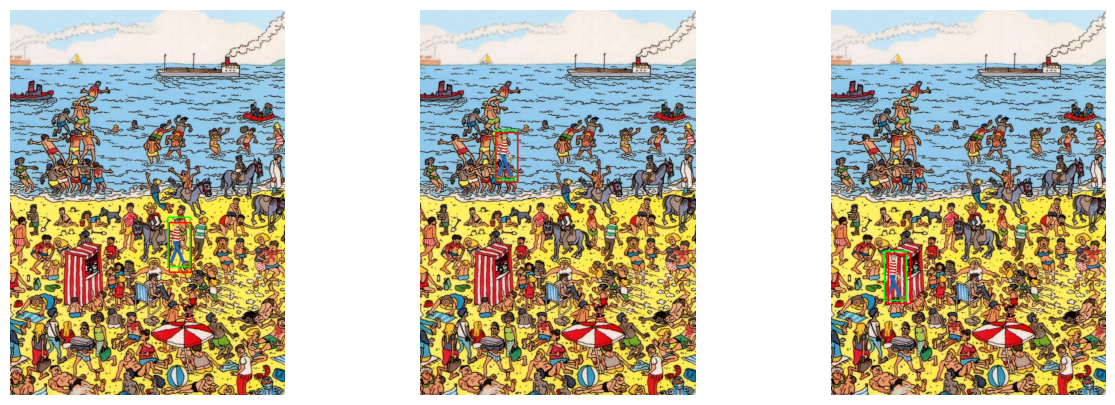

In [ ]:
#評估模型
model.evaluate(generate_data(), steps = 50)

#隨機測試3張圖片，並觀察偵測結果
test_model()

In [18]:
#儲存模型
import os
from google.colab import drive
from datetime import datetime

#掛載google雲端硬碟
try:
  drive.mount("/content/drive")
  print("Google Drive 掛載成功！")
except Exception as e:
  print("掛載 Google Drive 失敗:", e)

#資料夾不存在則建立一個
model_dir = "/content/drive/MyDrive/WheresWaldo/saved_models"
os.makedirs(model_dir, exist_ok=True)

#取得當前日期和時間
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

#儲存模型為 SavedModel 格式，命名包含日期
model_name = "WheresWaldo_{}.keras" .format(current_datetime)
model_path = os.path.join(model_dir, model_name)
model.save(model_path, include_optimizer=True)

if os.path.exists(model_path):
  print("模型已成功儲存於: {}" .format(model_path))
else:
  print("模型儲存失敗！")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 掛載成功！
模型已成功儲存於: /content/drive/MyDrive/WheresWaldo/saved_models/WheresWaldo_20250316_102302.keras


In [19]:
import tensorflow as tf

#載入模型
model = tf.keras.models.load_model(model_path, custom_objects={'mean_iou': mean_iou})

#查看模型架構
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1400, 1000, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1400, 1000, 8)       │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1400, 1000, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 700, 500, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 700, 500, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 700, 500, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 350, 250, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 348, 248, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 348, 248, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 174, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 172, 122, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 172, 122, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 86, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 167872)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      85,950,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,295,000 (985.32 MB)

 Trainable params: 86,098,274 (328.44 MB)

 Non-trainable params: 176 (704.00 B)

 Optimizer params: 172,196,550 (656.88 MB)

'\n#載入模型\n\nimport tensorflow as tf\n\nmodel = tf.keras.models.load_model("/content/drive/MyDrive/WheresWaldo/saved_models/WheresWaldo_0312.keras")\n\n#查看模型架構\nmodel.summary()\n'

In [ ]:
#成果展示

In [ ]:
print('push github test')